# Obtain necessary functions for the calculation of polarization from the magnetic field generated from COMSOL models

In [1]:
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
#import random
import scipy.integrate as spi
from scipy.integrate import solve_ivp
from scipy import interpolate
import warnings

In [2]:
%matplotlib inline
#suppress warnings
warnings.filterwarnings('ignore')

The text file with x, y,,z co-ordinate and the corresponding magnetic fileds is created using quard COMSOL model.<br>
I am using panda dataframe to read this file.<br>

In [3]:
p=pd.read_csv('MagneticFieldFromSIM_ABSMagnetSystem.txt',delim_whitespace=True)
df       = pd.DataFrame(p)
df

,x,y,z,Bx,By,Bz
0,0.010931,0.010931,0.017293,-0.001596,0.001571,0.000059
1,0.016397,0.000000,0.017172,-0.002189,-0.000188,-0.001170
2,0.000000,0.000000,0.026997,0.000033,-0.000171,0.000187
3,0.000000,0.000000,0.000000,0.000358,-0.000324,0.000279
4,0.032107,0.014281,0.000000,0.000009,-0.000104,-0.003250
...,...,...,...,...,...,...
50777,0.664426,0.100500,1.896894,-0.004435,0.000146,0.001333
50778,0.666604,0.080741,1.934553,-0.007565,-0.000512,0.000967
50779,0.661011,0.120943,1.930915,-0.004452,-0.000206,0.000871
50780,0.668940,0.063890,1.906515,-0.004393,0.000410,0.000877


This COMSOL model works on the 1/8 th symmetry.<br>
Hence, I artifically expanded the solution to cover all regions.
1st quarter id divided into half by 45 degree angle.<br> 
<br>
To get all points on 1st quarter we change x by y and y by x.<br> 
2nd quarter is the same of 1st quarter with x=-x<br>
3rd quarter is the same of 1st quarter with x=-x and y=-y<br>
4th quarter is the same of 1st quarter with y=-y<br>

In [4]:
df_OtherHalf = df.rename(columns={'x': 'y','y': 'x'})
df_OtherHalf

,y,x,z,Bx,By,Bz
0,0.010931,0.010931,0.017293,-0.001596,0.001571,0.000059
1,0.016397,0.000000,0.017172,-0.002189,-0.000188,-0.001170
2,0.000000,0.000000,0.026997,0.000033,-0.000171,0.000187
3,0.000000,0.000000,0.000000,0.000358,-0.000324,0.000279
4,0.032107,0.014281,0.000000,0.000009,-0.000104,-0.003250
...,...,...,...,...,...,...
50777,0.664426,0.100500,1.896894,-0.004435,0.000146,0.001333
50778,0.666604,0.080741,1.934553,-0.007565,-0.000512,0.000967
50779,0.661011,0.120943,1.930915,-0.004452,-0.000206,0.000871
50780,0.668940,0.063890,1.906515,-0.004393,0.000410,0.000877


In [5]:
df_1stq=df.append(df_OtherHalf)
df_1stq

,x,y,z,Bx,By,Bz
0,0.010931,0.010931,0.017293,-0.001596,0.001571,0.000059
1,0.016397,0.000000,0.017172,-0.002189,-0.000188,-0.001170
2,0.000000,0.000000,0.026997,0.000033,-0.000171,0.000187
3,0.000000,0.000000,0.000000,0.000358,-0.000324,0.000279
4,0.032107,0.014281,0.000000,0.000009,-0.000104,-0.003250
...,...,...,...,...,...,...
50777,0.100500,0.664426,1.896894,-0.004435,0.000146,0.001333
50778,0.080741,0.666604,1.934553,-0.007565,-0.000512,0.000967
50779,0.120943,0.661011,1.930915,-0.004452,-0.000206,0.000871
50780,0.063890,0.668940,1.906515,-0.004393,0.000410,0.000877


In [6]:
df_2ndq=df_1stq.copy()
df_2ndq.x=df_2ndq.x*-1
df_2ndq

,x,y,z,Bx,By,Bz
0,-0.010931,0.010931,0.017293,-0.001596,0.001571,0.000059
1,-0.016397,0.000000,0.017172,-0.002189,-0.000188,-0.001170
2,-0.000000,0.000000,0.026997,0.000033,-0.000171,0.000187
3,-0.000000,0.000000,0.000000,0.000358,-0.000324,0.000279
4,-0.032107,0.014281,0.000000,0.000009,-0.000104,-0.003250
...,...,...,...,...,...,...
50777,-0.100500,0.664426,1.896894,-0.004435,0.000146,0.001333
50778,-0.080741,0.666604,1.934553,-0.007565,-0.000512,0.000967
50779,-0.120943,0.661011,1.930915,-0.004452,-0.000206,0.000871
50780,-0.063890,0.668940,1.906515,-0.004393,0.000410,0.000877


In [7]:
df_3rdq=df_2ndq.copy()
df_3rdq.y=df_3rdq.y*-1
df_3rdq

,x,y,z,Bx,By,Bz
0,-0.010931,-0.010931,0.017293,-0.001596,0.001571,0.000059
1,-0.016397,-0.000000,0.017172,-0.002189,-0.000188,-0.001170
2,-0.000000,-0.000000,0.026997,0.000033,-0.000171,0.000187
3,-0.000000,-0.000000,0.000000,0.000358,-0.000324,0.000279
4,-0.032107,-0.014281,0.000000,0.000009,-0.000104,-0.003250
...,...,...,...,...,...,...
50777,-0.100500,-0.664426,1.896894,-0.004435,0.000146,0.001333
50778,-0.080741,-0.666604,1.934553,-0.007565,-0.000512,0.000967
50779,-0.120943,-0.661011,1.930915,-0.004452,-0.000206,0.000871
50780,-0.063890,-0.668940,1.906515,-0.004393,0.000410,0.000877


In [8]:
df_4thq=df_1stq.copy()
df_4thq.y=df_4thq.y*-1
df_4thq

,x,y,z,Bx,By,Bz
0,0.010931,-0.010931,0.017293,-0.001596,0.001571,0.000059
1,0.016397,-0.000000,0.017172,-0.002189,-0.000188,-0.001170
2,0.000000,-0.000000,0.026997,0.000033,-0.000171,0.000187
3,0.000000,-0.000000,0.000000,0.000358,-0.000324,0.000279
4,0.032107,-0.014281,0.000000,0.000009,-0.000104,-0.003250
...,...,...,...,...,...,...
50777,0.100500,-0.664426,1.896894,-0.004435,0.000146,0.001333
50778,0.080741,-0.666604,1.934553,-0.007565,-0.000512,0.000967
50779,0.120943,-0.661011,1.930915,-0.004452,-0.000206,0.000871
50780,0.063890,-0.668940,1.906515,-0.004393,0.000410,0.000877


In [9]:
df_Final=pd.concat([df_1stq, df_2ndq, df_3rdq,df_4thq],ignore_index=True)
df_Final

,x,y,z,Bx,By,Bz
0,0.010931,0.010931,0.017293,-0.001596,0.001571,0.000059
1,0.016397,0.000000,0.017172,-0.002189,-0.000188,-0.001170
2,0.000000,0.000000,0.026997,0.000033,-0.000171,0.000187
3,0.000000,0.000000,0.000000,0.000358,-0.000324,0.000279
4,0.032107,0.014281,0.000000,0.000009,-0.000104,-0.003250
...,...,...,...,...,...,...
406251,0.100500,-0.664426,1.896894,-0.004435,0.000146,0.001333
406252,0.080741,-0.666604,1.934553,-0.007565,-0.000512,0.000967
406253,0.120943,-0.661011,1.930915,-0.004452,-0.000206,0.000871
406254,0.063890,-0.668940,1.906515,-0.004393,0.000410,0.000877


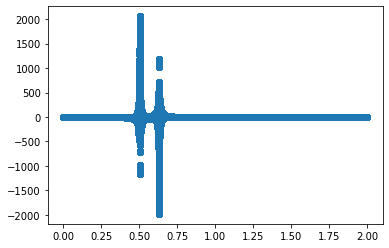

In [10]:
plt.scatter(df_Final['z'],df_Final['Bz'])

Now As we have verified that this program can create all data from 1/8th symmetry.<br>
<br>
Now, define a function.<br>

In [11]:
def ConstructAllData(T):
    p=pd.read_csv(T,delim_whitespace=True)
    df       = pd.DataFrame(p)
    df_OtherHalf = df.rename(columns={'x': 'y','y': 'x'})
    df_1stq=df.append(df_OtherHalf)
    df_2ndq=df_1stq.copy()
    df_2ndq.x=df_2ndq.x*-1
    df_3rdq=df_2ndq.copy()
    df_3rdq.y=df_3rdq.y*-1
    df_4thq=df_1stq.copy()
    df_4thq.y=df_4thq.y*-1
    df_Final=pd.concat([df_1stq, df_2ndq, df_3rdq,df_4thq],ignore_index=True)
    df_Final
    return df_Final

In [12]:
T='MagneticFieldFromSIM_ABSMagnetSystem.txt'

In [13]:
T1=ConstructAllData(T)

In [14]:
T1["Norm"]=(T1["Bx"]**2+T1["By"]**2+T1["Bz"]**2)**0.5

In [15]:
T1

,x,y,z,Bx,By,Bz,Norm
0,0.010931,0.010931,0.017293,-0.001596,0.001571,0.000059,0.002240
1,0.016397,0.000000,0.017172,-0.002189,-0.000188,-0.001170,0.002489
2,0.000000,0.000000,0.026997,0.000033,-0.000171,0.000187,0.000256
3,0.000000,0.000000,0.000000,0.000358,-0.000324,0.000279,0.000558
4,0.032107,0.014281,0.000000,0.000009,-0.000104,-0.003250,0.003252
...,...,...,...,...,...,...,...
406251,0.100500,-0.664426,1.896894,-0.004435,0.000146,0.001333,0.004633
406252,0.080741,-0.666604,1.934553,-0.007565,-0.000512,0.000967,0.007644
406253,0.120943,-0.661011,1.930915,-0.004452,-0.000206,0.000871,0.004541
406254,0.063890,-0.668940,1.906515,-0.004393,0.000410,0.000877,0.004499


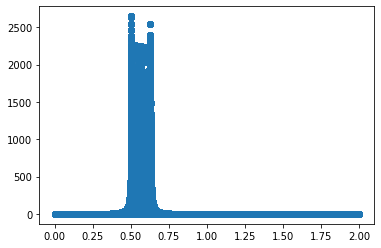

In [16]:
plt.scatter(T1["z"],T1["Norm"])

Now make a function which obtain corresponding magnetic fields at at a given co-ordinates.<br>
I define x as a co-ordinate, where we need to obtain the magnetic field.<br>
Lets define one more column in thr dataframe, this is 3D difference between the solution at node point to the given co-ordinate.<br> 

In [17]:
x=[0.1,0.03,0.3]
T1["Del"]=((T1["x"]-x[0])**2+(T1["y"]-x[1])**2+(T1["z"]-x[2])**2)**0.5
T1

,x,y,z,Bx,By,Bz,Norm,Del
0,0.010931,0.010931,0.017293,-0.001596,0.001571,0.000059,0.002240,0.297018
1,0.016397,0.000000,0.017172,-0.002189,-0.000188,-0.001170,0.002489,0.296447
2,0.000000,0.000000,0.026997,0.000033,-0.000171,0.000187,0.000256,0.292285
3,0.000000,0.000000,0.000000,0.000358,-0.000324,0.000279,0.000558,0.317648
4,0.032107,0.014281,0.000000,0.000009,-0.000104,-0.003250,0.003252,0.307988
...,...,...,...,...,...,...,...,...
406251,0.100500,-0.664426,1.896894,-0.004435,0.000146,0.001333,0.004633,1.741350
406252,0.080741,-0.666604,1.934553,-0.007565,-0.000512,0.000967,0.007644,1.776905
406253,0.120943,-0.661011,1.930915,-0.004452,-0.000206,0.000871,0.004541,1.771388
406254,0.063890,-0.668940,1.906515,-0.004393,0.000410,0.000877,0.004499,1.752344


In [18]:
ts=T1["Norm"]
ts

0         0.002240
1         0.002489
2         0.000256
3         0.000558
4         0.003252
            ...   
406251    0.004633
406252    0.007644
406253    0.004541
406254    0.004499
406255    0.004454
Name: Norm, Length: 406256, dtype: float64

<AxesSubplot:>

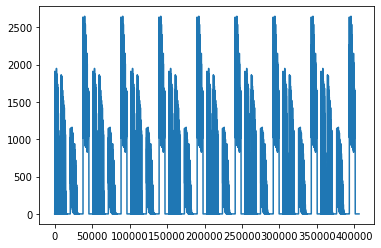

In [19]:

ts.interpolate(method='spline',order= 3).plot()

Now obtain the corresponding magnetic filed, which have smallest 3D distance.<br> 

In [20]:
b=T1["Del"].idxmin()

In [21]:
c=T1.iloc[b]["Bx"]
d=T1.iloc[b]["By"]
e=T1.iloc[b]["Bz"]
f=T1.iloc[b]["Norm"]
B=[c,d,e,f]

Now define a function to get the magnetic field at given time.<br>

In [22]:
def ObtainCorrespondingMagneticField(x,v,t):
    xt=[x0[0]+v[0]*t,x0[1]+v[1]*t,x0[2]+v[2]*t]
    #xt[0]=xt[0]/100;
    #xt[1]=xt[1]/100;
    #xt[2]=xt[2]/100;
    T1["Del"]=((T1["x"]*100-xt[0])**2+(T1["y"]*100-xt[1])**2+(T1["z"]*100-xt[2])**2)**0.5
    b=T1["Del"].idxmin()
    B=[T1.iloc[b]["Bx"],T1.iloc[b]["By"],T1.iloc[b]["Bz"]]
    return B
    

Then, the magnetic field at a co-ordinate (with a stationary points)

In [23]:
def ObtainB0(x):
    #x[0]=x[0]/100;
    #x[1]=x[1]/100;
    #x[2]=x[2]/100;
    T1["Del"]=((T1["x"]*100-x[0])**2+(T1["y"]*100-x[1])**2+(T1["z"]*100-x[2])**2)**0.5
    b=T1["Del"].idxmin()
    B=[T1.iloc[b]["Bx"],T1.iloc[b]["By"],T1.iloc[b]["Bz"]]
    return B

Now, we are in a position to obtain the polarization:

In [24]:
#start work to calculate polarization
#intial parameters
g=20378.9; v3=22000;
z0=62.5;
r0=0.629;
z1=200;
r1=5.;
num_points=10;
div=(r1+r0)/(z1-z0);

This is a function we already define in PolarizationSimulation.py<br>

In [25]:
Pol=[]; 
r0=0.629;
for n in range (1,num_points):
    
    phi = np.random.uniform(0,2*np.pi)
    rho=9999;
    #while (abs(rho)>r0):
    #    rho = np.random.normal(loc = 0, scale = 0.25, size = 1)*r0
    rho=np.sqrt(np.random.uniform(0,1))*r0
    x0=[ rho*np.cos(phi), rho*np.sin(phi), z0 ];
    
    B0=ObtainB0(x0);
    #obtain norm of the magnetic field
    B0t=np.linalg.norm(B0,axis=0);
    
    r=99999; 
    #make sure the generated values are within the radius of the pipe.
    while(r>r1):  
        ctheta=1-(1-np.cos(div))*np.random.uniform(0,1);
        v1=(v3*math.sqrt(1-pow(ctheta,2))*np.cos(phi), v3*math.sqrt(1-pow(ctheta,2))*np.sin(phi), v3*ctheta );
        x1=np.array(x0)
        v=np.array(v1)
        t1=(z1-z0)/v[2];
        x1=x0+(v*t1);
        #r=3;
        r2=np.sqrt(x0[0]*x0[0] + x0[1]*x0[1]);
        r=np.sqrt(x1[0]*x1[0] + x1[1]*x1[1]);
        B1  = ObtainB0(x1)
        B1t = np.linalg.norm(B1,axis=0);
    
    sol = solve_ivp(lambda t, y: g*np.cross(y, ObtainCorrespondingMagneticField(x0,v,t)), [0,t1], B0/B0t, method="RK45", rtol = 1e-5)
    #obtain last elemet of the array from the ode solution
    Mx=sol.y[0][-1]
    My=sol.y[1][-1]
    Mz=sol.y[2][-1]
    #norm of output vector of the ode
    Mn=np.sqrt(Mx**2+My**2+Mz**2)
    
    #polarization is given by 
    pol=(B1[0]*Mx+B1[1]*My+B1[2]*Mz)/(Mn*B1t)
    Pol.append(pol)
    

In [26]:
np.mean(Pol)

0.1606153256208258

<function matplotlib.pyplot.show(close=None, block=None)>

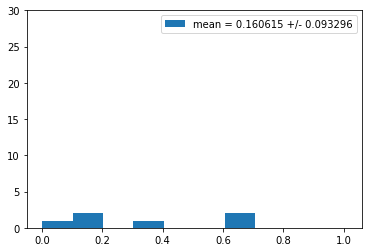

In [27]:
plt.hist(Pol,10,range=[0.0,1.01]);
plt.ylim([0, 30])
plt.legend(["mean = "+str("{:.6f}".format(np.mean(Pol)))+" +/- "+str("{:.6f}".format(np.std(Pol)/np.sqrt(num_points))) ] )
plt.show

In [31]:
math.atan2(0.1,-0.1)

2.356194490192345

In [30]:
t_i=0
t_f=0.00632020464509843
for t in range (0, 11,1):
    step=(t_f-t_i)/10 #difference time /difference in range
    ti=t_i+t*step
    print(ti)

0.0
0.000632020464509843
0.001264040929019686
0.001896061393529529
0.002528081858039372
0.003160102322549215
0.003792122787059058
0.004424143251568901
0.005056163716078744
0.005688184180588586
0.00632020464509843
